### Sim

In [1]:
import numpy as np
import random
import itertools

# Constants
MAGENTA = 'M'
YELLOW = 'Y'

# Global counters & records
individual_id_counter = 1
genetic_data_records = []
chromatid_recombination_records = []

def build_forward_generations(base_name, start_gen, end_gen):
    """
    Build F-generations: e.g., F2 to F5 as [('F2', 'F1', 'F1'), ('F3', 'F2', 'F2'), ...]
    """
    plan = []
    for i in range(start_gen + 1, end_gen + 1):
        current = f"{base_name}{i}"
        parent = f"{base_name}{i-1}"
        plan.append((current, parent, parent))
    return plan

def build_backcross_generations(base_name, recurrent_parent, donor_parent, num_backcrosses):
    """
    Build backcross generations: e.g., BC1 = F1 × P_A, BC2 = BC1 × P_A, etc.
    """
    plan = []
    prev = donor_parent  # F1 typically
    for i in range(1, num_backcrosses + 1):
        current = f"{base_name}{i}"
        plan.append((current, prev, recurrent_parent))
        prev = current  # Next round uses this backcrossed generation
    return plan

# Classes
class Chromosome:
    def __init__(self, alleles):
        self.alleles = alleles

    def __repr__(self):
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"

class DiploidChromosomePair:
    def __init__(self, chromatid1, chromatid2):
        self.chromatid1 = chromatid1
        self.chromatid2 = chromatid2

    def __repr__(self):
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"

class Individual:
    def __init__(self, num_chromosomes, num_loci_per_chromosome):
        global individual_id_counter
        self.id = individual_id_counter
        individual_id_counter += 1

        self.num_chromosomes = num_chromosomes
        self.num_loci_per_chromosome = num_loci_per_chromosome
        self.diploid_chromosome_pairs = []

    def __repr__(self):
        return f"Individual(ID: {self.id}, Chromosomes: {len(self.diploid_chromosome_pairs)})"

    def get_all_numeric_genotypes(self):
        all_numeric = []
        for pair in self.diploid_chromosome_pairs:
            a1 = pair.chromatid1.alleles
            a2 = pair.chromatid2.alleles
            for i in range(self.num_loci_per_chromosome):
                pair_sorted = sorted([a1[i], a2[i]])
                if pair_sorted == [MAGENTA, MAGENTA]:
                    all_numeric.append(2)
                elif pair_sorted == [YELLOW, YELLOW]:
                    all_numeric.append(0)
                else:
                    all_numeric.append(1)
        return all_numeric

    def calculate_hybrid_index(self):
        all_numeric = self.get_all_numeric_genotypes()
        total_alleles = len(all_numeric) * 2
        if total_alleles == 0:
            return 0.0
        sum_m = sum(all_numeric)
        return sum_m / total_alleles

    def calculate_heterozygosity(self):
        all_numeric = self.get_all_numeric_genotypes()
        if len(all_numeric) == 0:
            return 0.0
        return all_numeric.count(1) / len(all_numeric)

    def get_chromatid_block_data(self):
        results = []
        for chr_idx, pair in enumerate(self.diploid_chromosome_pairs):
            for chromatid_idx, chromatid in enumerate([pair.chromatid1, pair.chromatid2]):
                junctions, lengths, alleles = self._analyse_single_chromatid(chromatid.alleles)
                results.append({
                    'individual_id': self.id,
                    'diploid_chr_id': chr_idx + 1,
                    'chromatid_in_pair': 'A' if chromatid_idx == 0 else 'B',
                    'total_junctions': junctions,
                    'block_lengths': lengths,
                    'block_alleles': alleles
                })
        return results


    def _analyse_single_chromatid(self, alleles):
        if not alleles:
            return 0, [], []
        block_lengths = []
        block_alleles = []
        for allele, group in itertools.groupby(alleles):
            group_list = list(group)
            block_lengths.append(len(group_list))
            block_alleles.append(allele)
        junctions = len(block_lengths) - 1 if block_lengths else 0
        return junctions, block_lengths, block_alleles

# Recording functions
def record_individual_genome(individual, generation_label):
    for chr_idx, pair in enumerate(individual.diploid_chromosome_pairs):
        for locus_idx in range(individual.num_loci_per_chromosome):
            allele_a = pair.chromatid1.alleles[locus_idx]
            allele_b = pair.chromatid2.alleles[locus_idx]
            genotype_str = f"{allele_a}|{allele_b}"
            genetic_data_records.append({
                'generation': generation_label,
                'individual_id': individual.id,
                'diploid_chr_id': chr_idx + 1,
                'locus_position': locus_idx,
                'genotype': genotype_str
            })

def record_chromatid_recombination(individual, generation_label):
    chromatid_data = individual.get_chromatid_block_data()
    for record in chromatid_data:
        record['generation'] = generation_label
        chromatid_recombination_records.append(record)

# Recombination simulation
def meiosis_with_recombination(diploid_pair, recomb_event_probabilities, recomb_probabilities):
    loci = diploid_pair.chromatid1.alleles
    loci_len = len(loci)

    n_events = random.choices(
        population=[0,1,2],
        weights=[recomb_event_probabilities.get(i,0) for i in [0,1,2]],
        k=1
    )[0]

    possible_positions = list(range(1, loci_len))
    if n_events > 0:
        weights = recomb_probabilities[1:loci_len]
        weights_sum = sum(weights)
        if weights_sum == 0:
            chosen_positions = sorted(random.sample(possible_positions, n_events))
        else:
            norm_weights = [w/weights_sum for w in weights]
            chosen_positions = sorted(random.choices(possible_positions, weights=norm_weights, k=n_events))
    else:
        chosen_positions = []

    parent1 = diploid_pair.chromatid1.alleles
    parent2 = diploid_pair.chromatid2.alleles
    recombinant_alleles = []
    last_pos = 0
    source = 0
    breakpoints = chosen_positions + [loci_len]

    for pos in breakpoints:
        if source == 0:
            recombinant_alleles.extend(parent1[last_pos:pos])
        else:
            recombinant_alleles.extend(parent2[last_pos:pos])
        source = 1 - source
        last_pos = pos

    return Chromosome(recombinant_alleles)

# Cross simulation
def run_genetic_cross(parents_pop_A, parents_pop_B, num_offspring_to_create,
                      generation_label, num_chromosomes_for_offspring,
                      recomb_event_probabilities, recomb_probabilities):
    offspring = []
    for _ in range(num_offspring_to_create):
        parent_A = random.choice(parents_pop_A)
        parent_B = random.choice(parents_pop_B)
        child = Individual(num_chromosomes_for_offspring, parent_A.num_loci_per_chromosome)

        for chr_idx in range(num_chromosomes_for_offspring):
            diploid_pair_A = parent_A.diploid_chromosome_pairs[chr_idx]
            diploid_pair_B = parent_B.diploid_chromosome_pairs[chr_idx]

            haploid_from_A = meiosis_with_recombination(diploid_pair_A, recomb_event_probabilities, recomb_probabilities)
            haploid_from_B = meiosis_with_recombination(diploid_pair_B, recomb_event_probabilities, recomb_probabilities)

            child.diploid_chromosome_pairs.append(DiploidChromosomePair(haploid_from_A, haploid_from_B))

        record_individual_genome(child, generation_label)
        record_chromatid_recombination(child, generation_label)
        offspring.append(child)

    return offspring

# Create pure individuals and populations
def create_pure_individual(num_chromosomes, num_loci_per_chr, allele_type):
    individual = Individual(num_chromosomes, num_loci_per_chr)
    for _ in range(num_chromosomes):
        chr_alleles = [allele_type] * num_loci_per_chr
        chromatid1 = Chromosome(chr_alleles[:])
        chromatid2 = Chromosome(chr_alleles[:])
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))
    return individual

def create_pure_population(num_individuals, num_chromosomes, num_loci_per_chr, allele_type):
    return [create_pure_individual(num_chromosomes, num_loci_per_chr, allele_type) for _ in range(num_individuals)]

def create_F1_population(pure_pop_A, pure_pop_B, recomb_event_probabilities, recomb_probabilities):
    if len(pure_pop_A) != len(pure_pop_B):
        raise ValueError("Pure populations must be same size to create F1 population")

    f1_population = []
    for i in range(len(pure_pop_A)):
        parent_A = pure_pop_A[i]
        parent_B = pure_pop_B[i]

        child = Individual(parent_A.num_chromosomes, parent_A.num_loci_per_chromosome)
        child.diploid_chromosome_pairs = []

        for chr_idx in range(parent_A.num_chromosomes):
            chr_A = parent_A.diploid_chromosome_pairs[chr_idx]
            chr_B = parent_B.diploid_chromosome_pairs[chr_idx]

            haploid_A = meiosis_with_recombination(chr_A, recomb_event_probabilities, recomb_probabilities)
            haploid_B = meiosis_with_recombination(chr_B, recomb_event_probabilities, recomb_probabilities)

            child.diploid_chromosome_pairs.append(DiploidChromosomePair(haploid_A, haploid_B))
        f1_population.append(child)
    return f1_population

# Helper to calculate population stats for reporting
def population_stats(pop):
    his = [ind.calculate_hybrid_index() for ind in pop]
    hets = [ind.calculate_heterozygosity() for ind in pop]
    return {
        'mean_HI': np.mean(his) if his else 0,
        'std_HI': np.std(his) if his else 0,
        'mean_HET': np.mean(hets) if hets else 0,
        'std_HET': np.std(hets) if hets else 0,
        'count': len(pop)
    }

def simulate_generations(
    initial_pop_A=None,
    initial_pop_B=None,
    generation_plan=None,
    num_offspring_per_cross=2,
    num_chromosomes=2,
    recomb_event_probabilities=None,
    recomb_probabilities=None,
    existing_populations=None,
    verbose=False,
):
    # Initialize populations dict
    populations = existing_populations if existing_populations is not None else {}

    # If initial pops provided and not already in populations, add them
    if initial_pop_A is not None and 'P_A' not in populations:
        populations['P_A'] = initial_pop_A
    if initial_pop_B is not None and 'P_B' not in populations:
        populations['P_B'] = initial_pop_B

    # Process subsequent generations based on generation_plan
    for gen_info in generation_plan:
        if gen_info == ('F1',):
            continue  # already done above

        gen_name = gen_info[0]
        parents_names = gen_info[1:]

        # Validate parents exist
        for p in parents_names:
            if p not in populations:
                raise ValueError(f"Parent population '{p}' not found for generation '{gen_name}'")

        # Cross parents to create new generation
        parents_pop_A = populations[parents_names[0]]
        parents_pop_B = populations[parents_names[1]]

        new_pop = run_genetic_cross(
            parents_pop_A,
            parents_pop_B,
            num_offspring_per_cross,
            gen_name,
            num_chromosomes,
            recomb_event_probabilities,
            recomb_probabilities
        )

        populations[gen_name] = new_pop
        if verbose:
            stats = population_stats(new_pop)
            print(f"{gen_name} created with {len(new_pop)} individuals from parents {parents_names} | Mean HI: {stats['mean_HI']:.3f} (±{stats['std_HI']:.3f}), Mean HET: {stats['mean_HET']:.3f} (±{stats['std_HET']:.3f})")

    return populations


In [2]:
#Example Run: 

# Parameters and example usage

num_chromosomes = 2
num_loci_per_chr = 100
num_offspring_per_cross = 10

# Recombination event probabilities (example: 0 events = 10%, 1 event = 85%, 2 events = 5%)
recomb_event_probabilities = {0: 0, 1: 1, 2: 0}

# Recombination probability along chromosome loci (U-shaped example: higher at ends)
#recomb_probabilities = [0] + [0.9 if i == 1 or i == num_loci_per_chr - 1 else 0.1 for i in range(1, num_loci_per_chr)]

# Uniform recombination probability across chromosome loci
# (e.g., equal chance of crossover at each possible position except the first)
recomb_probabilities = [0] + [1/(num_loci_per_chr - 1)] * (num_loci_per_chr - 1)

# Assume your full code (classes, functions, constants) is already defined above

# Parameters
num_individuals_per_pure_pop = 5
num_chromosomes = 2
num_loci_per_chr = 20

# Recombination parameters (example)
recomb_event_probabilities = {0: 0.1, 1: 0.85, 2: 0.05}
recomb_probabilities = [0] + [1]*(num_loci_per_chr - 1)  # uniform recomb prob across loci for simplicity

# 1. Create pure populations
pure_pop_A = create_pure_population(num_individuals_per_pure_pop, num_chromosomes, num_loci_per_chr, MAGENTA)
pure_pop_B = create_pure_population(num_individuals_per_pure_pop, num_chromosomes, num_loci_per_chr, YELLOW)

# 2. Record pure populations
for ind in pure_pop_A:
    record_individual_genome(ind, 'P_A')
    record_chromatid_recombination(ind, 'P_A')

for ind in pure_pop_B:
    record_individual_genome(ind, 'P_B')
    record_chromatid_recombination(ind, 'P_B')

# 3. Create F1 population from pure parents (same sizes)
f1_pop = create_F1_population(
    pure_pop_A,
    pure_pop_B,
    recomb_event_probabilities,
    recomb_probabilities
)

# 4. Record F1 population
for ind in f1_pop:
    record_individual_genome(ind, 'F1')
    record_chromatid_recombination(ind, 'F1')

populations = {
    'P_A': pure_pop_A,
    'P_B': pure_pop_B,
    'F1': f1_pop
}

# 5. Print summary stats
def print_stats(pop, label):
    stats = population_stats(pop)
    print(f"{label} | Count: {stats['count']} | Mean HI: {stats['mean_HI']:.3f} (±{stats['std_HI']:.3f}), Mean HET: {stats['mean_HET']:.3f} (±{stats['std_HET']:.3f})")

print_stats(pure_pop_A, 'Pure Pop A')
print_stats(pure_pop_B, 'Pure Pop B')
print_stats(f1_pop, 'F1 Population')

Pure Pop A | Count: 5 | Mean HI: 1.000 (±0.000), Mean HET: 0.000 (±0.000)
Pure Pop B | Count: 5 | Mean HI: 0.000 (±0.000), Mean HET: 0.000 (±0.000)
F1 Population | Count: 5 | Mean HI: 0.500 (±0.000), Mean HET: 1.000 (±0.000)


In [3]:
def calculate_hi_het(population):
    hi_list = [ind.calculate_hybrid_index() for ind in population]
    het_list = [ind.calculate_heterozygosity() for ind in population]
    return hi_list, het_list

In [4]:
# Generation Setup
forward_plan = build_forward_generations("F", 1, 10)  
backcross_plan = build_backcross_generations("BC", "P_A", "F1", 2)  # BC1, BC2

generation_plan = forward_plan + backcross_plan
print(generation_plan)

# Starts from 0 counter need to fix this. 

[('F2', 'F1', 'F1'), ('F3', 'F2', 'F2'), ('F4', 'F3', 'F3'), ('F5', 'F4', 'F4'), ('F6', 'F5', 'F5'), ('F7', 'F6', 'F6'), ('F8', 'F7', 'F7'), ('F9', 'F8', 'F8'), ('F10', 'F9', 'F9'), ('BC1', 'F1', 'P_A'), ('BC2', 'BC1', 'P_A')]


In [5]:
populations = simulate_generations(
    initial_pop_A=None,
    initial_pop_B=None,
    generation_plan=generation_plan,
    num_offspring_per_cross=2,
    num_chromosomes=2,
    recomb_event_probabilities=recomb_event_probabilities,
    recomb_probabilities=recomb_probabilities,
    existing_populations={
        'P_A': pure_pop_A,
        'P_B': pure_pop_B,
        'F1': f1_pop
    },
    verbose=True
)

F2 created with 2 individuals from parents ('F1', 'F1') | Mean HI: 0.463 (±0.100), Mean HET: 0.400 (±0.075)
F3 created with 2 individuals from parents ('F2', 'F2') | Mean HI: 0.438 (±0.037), Mean HET: 0.350 (±0.150)
F4 created with 2 individuals from parents ('F3', 'F3') | Mean HI: 0.400 (±0.075), Mean HET: 0.025 (±0.025)
F5 created with 2 individuals from parents ('F4', 'F4') | Mean HI: 0.369 (±0.044), Mean HET: 0.087 (±0.087)
F6 created with 2 individuals from parents ('F5', 'F5') | Mean HI: 0.369 (±0.044), Mean HET: 0.087 (±0.087)
F7 created with 2 individuals from parents ('F6', 'F6') | Mean HI: 0.338 (±0.012), Mean HET: 0.025 (±0.025)
F8 created with 2 individuals from parents ('F7', 'F7') | Mean HI: 0.331 (±0.006), Mean HET: 0.013 (±0.013)
F9 created with 2 individuals from parents ('F8', 'F8') | Mean HI: 0.325 (±0.000), Mean HET: 0.000 (±0.000)
F10 created with 2 individuals from parents ('F9', 'F9') | Mean HI: 0.325 (±0.000), Mean HET: 0.000 (±0.000)
BC1 created with 2 individu

In [6]:
all_generations_data = {}
for gen_name, pop in populations.items():
    hi_list, het_list = calculate_hi_het(pop)
    all_generations_data[gen_name] = {'hi': hi_list, 'het': het_list}

p0_a_hi, p0_a_het = np.mean(all_generations_data['P_A']['hi']), np.mean(all_generations_data['P_A']['het'])
p0_b_hi, p0_b_het = np.mean(all_generations_data['P_B']['hi']), np.mean(all_generations_data['P_B']['het'])
f1_hi, f1_het = np.mean(all_generations_data['F1']['hi']), np.mean(all_generations_data['F1']['het'])


### Triangle Plot

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def plot_hi_het_triangle_all_generations(all_generations_data, p0_a_stats, p0_b_stats, f1_stats):
    """
    Plots hybrid index vs heterozygosity for all generations on the same triangle plot.

    Parameters:
        all_generations_data (dict): {generation_name: {'hi': [...], 'het': [...]}}
        p0_a_stats (tuple): (HI, HET) of P0_A (MM)
        p0_b_stats (tuple): (HI, HET) of P0_B (YY)
        f1_stats (tuple): (HI, HET) of F1 (averaged)
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.set_xlabel("Hybrid Index (proportion M alleles)", fontsize=12)
    ax.set_ylabel("Heterozygosity (proportion heterozygous loci)", fontsize=12)

    # Colors and alpha values for known generations
    generation_colors = {
        'F2': ('black', 1),
        'F3': ('orange', 0.25),
        'F4': ('pink', 1),
        'F5': ('green', 1),
        'F6': ('purple', 1),
        'F7': ('purple', 0.25),
        'F8': ('yellow', 1),
        'F9': ('brown', 1),
        'F10': ('green', 0.25),
        'BC1_A': ('blue', 0.7),
        'BC1_B': ('red', 0.7)
    }

    legend_elements = []

    # Plot all generations
    for gen_name, values in all_generations_data.items():
        color, alpha = generation_colors.get(gen_name, ('grey', 0.5))
        ax.scatter(values['hi'], values['het'], color=color, alpha=alpha, s=15, label=f'{gen_name} Population')
        legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8,
                                      alpha=alpha, label=f'{gen_name} Population'))

    # Plot parental and F1 reference points
    p0_a_hi, p0_a_het = p0_a_stats
    p0_b_hi, p0_b_het = p0_b_stats
    f1_hi, f1_het = f1_stats

    ax.scatter(p0_a_hi, p0_a_het, color='magenta', s=80, edgecolor='black', zorder=5, label='P0_A (MM)')
    ax.scatter(p0_b_hi, p0_b_het, color='yellow', s=80, edgecolor='black', zorder=5, label='P0_B (YY)')
    ax.scatter(f1_hi, f1_het, color='orange', s=80, edgecolor='black', zorder=5, label='F1')

    ax.annotate('P0_A', (p0_a_hi, p0_a_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    ax.annotate('P0_B', (p0_b_hi, p0_b_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    ax.annotate('F1', (f1_hi, f1_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

    # Draw triangle boundary
    triangle_edges = [
        [(0.0, 0.0), (0.5, 1.0)],
        [(0.5, 1.0), (1.0, 0.0)],
        [(0.0, 0.0), (1.0, 0.0)]
    ]
    for (x0, y0), (x1, y1) in triangle_edges:
        ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)

    # Add legend entries for reference individuals
    legend_elements.extend([
        Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='P0_A (MM)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='P0_B (YY)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1')
    ])

    ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.show()

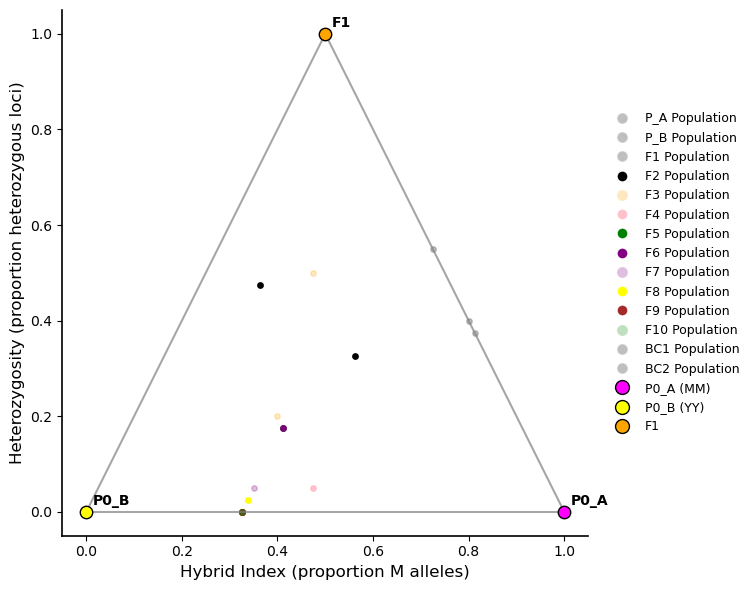

In [8]:
plot_hi_het_triangle_all_generations(
    all_generations_data,
    p0_a_stats=(p0_a_hi, p0_a_het),
    p0_b_stats=(p0_b_hi, p0_b_het),
    f1_stats=(f1_hi, f1_het)
)